In [1]:
import argparse
import scipy
from scipy import ndimage
import numpy as np
import sys

import torch
from torch.autograd import Variable
import torchvision.models as models
import torch.nn.functional as F
from torch.utils import data, model_zoo
from model.deeplab_multi import Res_Deeplab
from dataset.cityscapes_dataset import cityscapesDataSet
from collections import OrderedDict
import os
from PIL import Image

import matplotlib.pyplot as plt
import torch.nn as nn
from dataset.gta5_dataset import GTA5DataSet



# config

In [2]:
IMG_MEAN = np.array((104.00698793, 116.66876762, 122.67891434), dtype=np.float32)

MODEL = 'DeepLab'
BATCH_SIZE = 1
ITER_SIZE = 1
NUM_WORKERS = 4
DATA_DIRECTORY = './data/GTA5'
DATA_LIST_PATH = './dataset/gta5_list/train.txt'
IGNORE_LABEL = 255
INPUT_SIZE = '1280,720'
DATA_DIRECTORY_TARGET = './data/Cityscapes/data'
DATA_LIST_PATH_TARGET = './dataset/cityscapes_list/train.txt'
INPUT_SIZE_TARGET = '1024,512'
LEARNING_RATE = 2.5e-4
MOMENTUM = 0.9
NUM_CLASSES = 19
NUM_STEPS = 250000
NUM_STEPS_STOP = 100000  # early stopping
POWER = 0.9
RANDOM_SEED = 1234
RESTORE_FROM = 'http://vllab.ucmerced.edu/ytsai/CVPR18/DeepLab_resnet_pretrained_init-f81d91e8.pth'
SAVE_NUM_IMAGES = 2
SAVE_PRED_EVERY = 5000
SNAPSHOT_DIR = './snapshots/'
WEIGHT_DECAY = 0.0005

LEARNING_RATE_D = 1e-4
LAMBDA_SEG = 0.1
LAMBDA_ADV_TARGET1 = 0.0002
LAMBDA_ADV_TARGET2 = 0.001

TARGET = 'cityscapes'
SET = 'train'
palette = [128, 64, 128, 244, 35, 232, 70, 70, 70, 102, 102, 156, 190, 153, 153, 153, 153, 153, 250, 170, 30,
           220, 220, 0, 107, 142, 35, 152, 251, 152, 70, 130, 180, 220, 20, 60, 255, 0, 0, 0, 0, 142, 0, 0, 70,
           0, 60, 100, 0, 80, 100, 0, 0, 230, 119, 11, 32]

In [3]:
def colorize_mask(mask):
    # mask: numpy array of the mask
    new_mask = Image.fromarray(mask.astype(np.uint8)).convert('P')
    new_mask.putpalette(palette)

    return new_mask

# set arg parser

In [4]:
def set_arguments(args):
    """Parse all the arguments provided from the CLI.

    Returns:
      A list of parsed arguments.
    """
    parser = argparse.ArgumentParser(description="DeepLab-ResNet Network")
    parser.add_argument("--data-dir", type=str, default=DATA_DIRECTORY,
                        help="Path to the directory containing the Cityscapes dataset.")
    parser.add_argument("--data-dir-target", type=str, default=DATA_DIRECTORY_TARGET,
                        help="Path to the directory containing the target dataset.")
    parser.add_argument("--data-list", type=str, default=DATA_LIST_PATH,
                        help="Path to the file listing the images in the dataset.")
    parser.add_argument("--model", type=str, default=MODEL,
                        help="available options : DeepLab")
    parser.add_argument("--target", type=str, default=TARGET,
                        help="available options : cityscapes")
    parser.add_argument("--batch-size", type=int, default=BATCH_SIZE,
                        help="Number of images sent to the network in one step.")
    parser.add_argument("--iter-size", type=int, default=ITER_SIZE,
                        help="Accumulate gradients for ITER_SIZE iterations.")
    parser.add_argument("--num-workers", type=int, default=NUM_WORKERS,
                        help="number of workers for multithread dataloading.")
    parser.add_argument("--ignore-label", type=int, default=IGNORE_LABEL,
                        help="The index of the label to ignore during the training.")
    parser.add_argument("--input-size", type=str, default=INPUT_SIZE,
                        help="Comma-separated string with height and width of source images.")
    parser.add_argument("--data-list-target", type=str, default=DATA_LIST_PATH_TARGET,
                        help="Path to the file listing the images in the target dataset.")
    parser.add_argument("--input-size-target", type=str, default=INPUT_SIZE_TARGET,
                        help="Comma-separated string with height and width of target images.")
    parser.add_argument("--is-training", action="store_true",
                        help="Whether to updates the running means and variances during the training.")
    parser.add_argument("--learning-rate", type=float, default=LEARNING_RATE,
                        help="Base learning rate for training with polynomial decay.")
    parser.add_argument("--learning-rate-D", type=float, default=LEARNING_RATE_D,
                        help="Base learning rate for discriminator.")
    parser.add_argument("--lambda-seg", type=float, default=LAMBDA_SEG,
                        help="lambda_seg.")
    parser.add_argument("--lambda-adv-target1", type=float, default=LAMBDA_ADV_TARGET1,
                        help="lambda_adv for adversarial training.")
    parser.add_argument("--lambda-adv-target2", type=float, default=LAMBDA_ADV_TARGET2,
                        help="lambda_adv for adversarial training.")
    parser.add_argument("--momentum", type=float, default=MOMENTUM,
                        help="Momentum component of the optimiser.")
    parser.add_argument("--not-restore-last", action="store_true",
                        help="Whether to not restore last (FC) layers.")
    parser.add_argument("--num-classes", type=int, default=NUM_CLASSES,
                        help="Number of classes to predict (including background).")
    parser.add_argument("--num-steps", type=int, default=NUM_STEPS,
                        help="Number of training steps.")
    parser.add_argument("--num-steps-stop", type=int, default=NUM_STEPS_STOP,
                        help="Number of training steps for early stopping.")
    parser.add_argument("--power", type=float, default=POWER,
                        help="Decay parameter to compute the learning rate.")
    parser.add_argument("--random-mirror", action="store_true",
                        help="Whether to randomly mirror the inputs during the training.")
    parser.add_argument("--random-scale", action="store_true",
                        help="Whether to randomly scale the inputs during the training.")
    parser.add_argument("--random-seed", type=int, default=RANDOM_SEED,
                        help="Random seed to have reproducible results.")
    parser.add_argument("--restore-from", type=str, default=RESTORE_FROM,
                        help="Where restore model parameters from.")
    parser.add_argument("--save-num-images", type=int, default=SAVE_NUM_IMAGES,
                        help="How many images to save.")
    parser.add_argument("--save-pred-every", type=int, default=SAVE_PRED_EVERY,
                        help="Save summaries and checkpoint every often.")
    parser.add_argument("--snapshot-dir", type=str, default=SNAPSHOT_DIR,
                        help="Where to save snapshots of the model.")
    parser.add_argument("--weight-decay", type=float, default=WEIGHT_DECAY,
                        help="Regularisation parameter for L2-loss.")
    parser.add_argument("--gpu", type=int, default=0,
                        help="choose gpu device.")
    parser.add_argument("--set", type=str, default=SET,
                        help="choose adaptation set.")
    return parser.parse_args(args)


In [5]:
args = set_arguments("--restore-from ./snapshots/selu-10k-20180524/GTA5_50000.pth --snapshot-dir ./snapshots/GTA2Cityscapes_multi --lambda-seg 0.1 --lambda-adv-target1 0.0002 --lambda-adv-target2 0.001".split(' '))

In [6]:
args

Namespace(batch_size=1, data_dir='./data/GTA5', data_dir_target='./data/Cityscapes/data', data_list='./dataset/gta5_list/train.txt', data_list_target='./dataset/cityscapes_list/train.txt', gpu=0, ignore_label=255, input_size='1280,720', input_size_target='1024,512', is_training=False, iter_size=1, lambda_adv_target1=0.0002, lambda_adv_target2=0.001, lambda_seg=0.1, learning_rate=0.00025, learning_rate_D=0.0001, model='DeepLab', momentum=0.9, not_restore_last=False, num_classes=19, num_steps=250000, num_steps_stop=100000, num_workers=4, power=0.9, random_mirror=False, random_scale=False, random_seed=1234, restore_from='./snapshots/selu-10k-20180524/GTA5_50000.pth', save_num_images=2, save_pred_every=5000, set='train', snapshot_dir='./snapshots/GTA2Cityscapes_multi', target='cityscapes', weight_decay=0.0005)

# input and resize setting

In [7]:
input_size = (1280, 720)
input_size_target = (1024,512)
interp = nn.Upsample(size=(input_size[1], input_size[0]), align_corners=False, mode='nearest')
interp_target = nn.Upsample(size=(input_size_target[1], input_size_target[0]), mode='nearest')
interp_down = nn.Upsample(size=(input_size_target[1]/4, input_size_target[0]/4), mode='nearest')


# deeplab model

In [8]:
"""Create the model and start the evaluation process."""
gpu0 = args.gpu

In [9]:
model = Res_Deeplab(num_classes=args.num_classes)

if args.restore_from[:4] == 'http' :
    saved_state_dict = model_zoo.load_url(args.restore_from)
else:
    saved_state_dict = torch.load(args.restore_from)
model.load_state_dict(saved_state_dict)

model.eval()
model.cuda(gpu0)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=True)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=Fa

# loading data

In [10]:
trainloader = data.DataLoader(
    GTA5DataSet(args.data_dir, args.data_list, max_iters=args.num_steps * args.iter_size * args.batch_size,
                crop_size=input_size,
                scale=args.random_scale, mirror=args.random_mirror, mean=IMG_MEAN),
    batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers, pin_memory=True)


In [11]:
args.data_list

'./dataset/gta5_list/train.txt'

In [12]:
targetloader = data.DataLoader(cityscapesDataSet(args.data_dir_target, args.data_list_target,
                                                     max_iters=args.num_steps * args.iter_size * args.batch_size,
                                                     crop_size=input_size_target,
                                                     scale=False, mirror=args.random_mirror, mean=IMG_MEAN,
                                                     set=args.set),
                                   batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers,
                                   pin_memory=True)

In [13]:
trainloader_gen = enumerate(trainloader)
targetloader_gen = enumerate(targetloader)

# trainer source input shape

In [14]:
index, batch = next(trainloader_gen)

In [15]:
images, labels, _, name = batch
images = Variable(images).cuda(args.gpu)

In [16]:
labels.shape

torch.Size([1, 720, 1280])

In [19]:
labels.cpu().data[0].numpy()

array([[  2.,   2.,   2., ...,   2.,   2.,   2.],
       [  2.,   2.,   2., ...,   2.,   2.,   2.],
       [  2.,   2.,   2., ...,   2.,   2.,   2.],
       ...,
       [  0.,   0.,   0., ..., 255., 255., 255.],
       [  0.,   0.,   0., ..., 255., 255., 255.],
       [  0.,   0.,   0., ..., 255., 255., 255.]], dtype=float32)

In [18]:
labels.save('check_output/Image_source_domain_seg/%s_label.png' % (1))


AttributeError: 'Tensor' object has no attribute 'save'

In [17]:
labels[0]

tensor([[  10.,   10.,   10.,  ...,   10.,   10.,   10.],
        [  10.,   10.,   10.,  ...,   10.,   10.,   10.],
        [   5.,    5.,    5.,  ...,   10.,   10.,   10.],
        ...,
        [   0.,    0.,    0.,  ...,  255.,  255.,  255.],
        [   0.,    0.,    0.,  ...,  255.,  255.,  255.],
        [   0.,    0.,    0.,  ...,  255.,  255.,  255.]])

In [18]:
num_classes = 19

[1, 720, 1280, 19]

In [22]:
a = torch.ones([1, 19, 3 ,2]) * 5

In [25]:
b = torch.ones([1, 19, 3, 2]) * 2

In [26]:
a * b

tensor([[[[ 10.,  10.],
          [ 10.,  10.],
          [ 10.,  10.]],

         [[ 10.,  10.],
          [ 10.,  10.],
          [ 10.,  10.]],

         [[ 10.,  10.],
          [ 10.,  10.],
          [ 10.,  10.]],

         [[ 10.,  10.],
          [ 10.,  10.],
          [ 10.,  10.]],

         [[ 10.,  10.],
          [ 10.,  10.],
          [ 10.,  10.]],

         [[ 10.,  10.],
          [ 10.,  10.],
          [ 10.,  10.]],

         [[ 10.,  10.],
          [ 10.,  10.],
          [ 10.,  10.]],

         [[ 10.,  10.],
          [ 10.,  10.],
          [ 10.,  10.]],

         [[ 10.,  10.],
          [ 10.,  10.],
          [ 10.,  10.]],

         [[ 10.,  10.],
          [ 10.,  10.],
          [ 10.,  10.]],

         [[ 10.,  10.],
          [ 10.,  10.],
          [ 10.,  10.]],

         [[ 10.,  10.],
          [ 10.,  10.],
          [ 10.,  10.]],

         [[ 10.,  10.],
          [ 10.,  10.],
          [ 10.,  10.]],

         [[ 10.,  10.],
          [ 10

In [51]:
n_z =  torch.zeros(list(labels.shape) + [num_classes], dtype=torch.float64)

In [66]:
n, c, h, w = [1, 19, 720, 1280]

In [91]:
labels

tensor([[[  10.,   10.,   10.,  ...,    2.,    2.,    2.],
         [  10.,   10.,   10.,  ...,    2.,    2.,    2.],
         [  10.,   10.,   10.,  ...,    2.,    2.,    2.],
         ...,
         [   0.,    0.,    0.,  ...,  255.,  255.,  255.],
         [   0.,    0.,    0.,  ...,  255.,  255.,  255.],
         [   0.,    0.,    0.,  ...,  255.,  255.,  255.]]])

# can work

In [84]:
test = torch.zeros(n, h, w, c)
for i in range(num_class):
    test[:,:,:,i] = (labels == i) * 1

In [93]:
test[:,:,:,10]

tensor([[[ 1.,  1.,  1.,  ...,  0.,  0.,  0.],
         [ 1.,  1.,  1.,  ...,  0.,  0.,  0.],
         [ 1.,  1.,  1.,  ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]]])

In [ ]:
h, w = map(int, args.input_size_target.split(','))



In [102]:
inter_mini = nn.Upsample(scale_factor=2, mode='nearest')

In [103]:
a = inter_mini(test)

In [104]:
a.shape

torch.Size([1, 720, 2560, 38])

In [89]:
test[:,:,:,0].max()

tensor(1.)

In [ ]:
for i in range 

In [19]:
h = 1280
w = 720
zero_channel = torch.zeros((1, w, h))
labels_channel = torch.zeros((num_class, w, h)).cuda()

In [20]:
labels_channel.shape

torch.Size([19, 720, 1280])

In [21]:
for i in range(num_class):
    labels_channel[i] = torch.where(labels == i, input = labels, other = zero_channel).cuda()

In [22]:
 # re-assign labels to match the format of Cityscapes
label_copy = 255 * np.ones(label.shape, dtype=np.float32)



NameError: name 'label' is not defined

In [168]:
label_copy

array([[[[255., 255., 255., ..., 255., 255., 255.],
         [255., 255., 255., ..., 255., 255., 255.],
         [255., 255., 255., ..., 255., 255., 255.],
         ...,
         [255., 255., 255., ..., 255., 255., 255.],
         [255., 255., 255., ..., 255., 255., 255.],
         [255., 255., 255., ..., 255., 255., 255.]],

        [[255., 255., 255., ..., 255., 255., 255.],
         [255., 255., 255., ..., 255., 255., 255.],
         [255., 255., 255., ..., 255., 255., 255.],
         ...,
         [255., 255., 255., ..., 255., 255., 255.],
         [255., 255., 255., ..., 255., 255., 255.],
         [255., 255., 255., ..., 255., 255., 255.]],

        [[255., 255., 255., ..., 255., 255., 255.],
         [255., 255., 255., ..., 255., 255., 255.],
         [255., 255., 255., ..., 255., 255., 255.],
         ...,
         [255., 255., 255., ..., 255., 255., 255.],
         [255., 255., 255., ..., 255., 255., 255.],
         [255., 255., 255., ..., 255., 255., 255.]],

        ...,

  

In [190]:
files = range(19)

In [193]:
class_label = np.zeros(tuple([len(files)] + list(labels.shape[1:])), dtype=np.float32)


In [194]:
class_label.shape

(19, 720, 1280)

In [205]:
a = np.random.random_integers(3, 10, size = (5, 10))

C:\Users\VIPLAB\Anaconda2\envs\xiao\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: This function is deprecated. Please call randint(3, 10 + 1) instead
  """Entry point for launching an IPython kernel.


In [206]:
a

array([[10,  5,  7,  5,  4,  3, 10,  5,  6,  9],
       [ 4,  7,  8,  5,  5,  5,  8,  3,  7,  7],
       [10,  6,  7,  6,  8,  5,  6,  8,  8,  9],
       [10,  5,  7,  3, 10,  8,  5,  4,  8,  3],
       [ 7, 10,  9,  4,  6,  5,  4,  3, 10,  8]])

In [214]:
c = a.take(np.where(a>5)).assign(-1)


AttributeError: 'numpy.ndarray' object has no attribute 'assign'

In [213]:
c

-1

In [195]:
for i in range(19):
    class_label[i] = np.ones(class_label[class_label ==  i])

ValueError: sequence too large; cannot be greater than 32

In [ ]:
# revise part
# =======================

for i in len(self.files):
    class_label[i] = label_copy[label == k]
# =======================

In [ ]:
labels_channel

In [149]:
vec.shape

torch.Size([19, 720, 1280])

In [148]:
a, _ = torch.max(vec)

TypeError: iteration over a 0-d tensor

In [129]:
np.where(labels == 1)

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))

In [125]:
target.shape

torch.Size([638893])

In [112]:
predict.shape

torch.Size([1, 720, 1280, 3])

In [113]:
predict = predict[target_mask.view(n, h, w, 1).repeat(1, 1, 1, c)].view(-1, c)

In [96]:
name

['04755.png']

In [63]:
label = Variable(labels.long()).cuda(gpu0)

In [64]:
label

tensor([[[   8,    8,    8,  ...,    2,    2,    2],
         [   8,    8,    8,  ...,    2,    2,    2],
         [   8,    8,   10,  ...,    2,    2,    2],
         ...,
         [   0,    0,    0,  ...,  255,  255,  255],
         [   0,    0,    0,  ...,  255,  255,  255],
         [   0,    0,    0,  ...,  255,  255,  255]]], device='cuda:0')

In [61]:
label.shape

torch.Size([1, 720, 1280])

In [41]:
label = label.transpose(1, 2).transpose(2, 3).contiguous()

RuntimeError: dimension out of range (expected to be in range of [-3, 2], but got 3)

In [43]:
label_mask = (label >= 0) * (label !=255)

In [44]:
label_mask

tensor([[[ 1,  1,  1,  ...,  1,  1,  1],
         [ 1,  1,  1,  ...,  1,  1,  1],
         [ 1,  1,  1,  ...,  1,  1,  1],
         ...,
         [ 1,  1,  1,  ...,  0,  0,  0],
         [ 1,  1,  1,  ...,  0,  0,  0],
         [ 1,  1,  1,  ...,  0,  0,  0]]], dtype=torch.uint8, device='cuda:0')

In [45]:
target = target[target_mask]

NameError: name 'target' is not defined

In [37]:
labels.shape

torch.Size([1, 720, 1280])

In [38]:
images.shape

torch.Size([1, 3, 720, 1280])

In [16]:
img_var = Variable(images, volatile=True)
# img_var = nn.no_grad(img_var)
output1, output2 = model(img_var.cuda(gpu0))

C:\Users\VIPLAB\Anaconda2\envs\xiao\lib\site-packages\ipykernel_launcher.py:1: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  """Entry point for launching an IPython kernel.


In [17]:
output1.shape, output2.shape

(torch.Size([1, 19, 91, 161]), torch.Size([1, 19, 91, 161]))

In [18]:
del img_var, output1, output2

# trainer target input shape

In [19]:
index, batch = next(targetloader_gen)

In [20]:
image, _, name = batch

In [21]:
image.shape

torch.Size([1, 3, 512, 1024])

# get image sementic segmentation

In [22]:
img_var = Variable(image, volatile=True)
output1, output2 = model(img_var.cuda(gpu0))

C:\Users\VIPLAB\Anaconda2\envs\xiao\lib\site-packages\ipykernel_launcher.py:1: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  """Entry point for launching an IPython kernel.


In [148]:
interp_down(output2).shape

C:\Users\VIPLAB\Anaconda2\envs\xiao\lib\site-packages\torch\nn\functional.py:1749: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([1, 19, 128, 256])

In [112]:
output = interp(output2).cpu().data[0].numpy()

output = output.transpose(1,2,0)
output.shape

(720, 1280, 19)

In [117]:
output2.shape

torch.Size([1, 19, 65, 129])

In [147]:
interp_down(output2)

C:\Users\VIPLAB\Anaconda2\envs\xiao\lib\site-packages\torch\nn\functional.py:1749: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


tensor([[[[-9.7652e-01, -8.6285e-01, -6.3898e-01,  ..., -1.5824e+00,
           -1.8475e+00, -1.9821e+00],
          [-9.9878e-01, -9.1776e-01, -7.5820e-01,  ..., -1.5246e+00,
           -1.7893e+00, -1.9237e+00],
          [-1.0420e+00, -1.0243e+00, -9.8950e-01,  ..., -1.4124e+00,
           -1.6765e+00, -1.8105e+00],
          ...,
          [ 5.4960e+00,  5.4606e+00,  5.3909e+00,  ...,  8.1992e+00,
            8.2569e+00,  8.2861e+00],
          [ 5.3831e+00,  5.3628e+00,  5.3230e+00,  ...,  8.5191e+00,
            8.7008e+00,  8.7931e+00],
          [ 5.3249e+00,  5.3125e+00,  5.2880e+00,  ...,  8.6840e+00,
            8.9297e+00,  9.0544e+00]],

         [[-3.3250e+00, -3.4798e+00, -3.7848e+00,  ..., -3.1842e+00,
           -3.0699e+00, -3.0118e+00],
          [-3.5730e+00, -3.6955e+00, -3.9368e+00,  ..., -3.1478e+00,
           -3.0093e+00, -2.9390e+00],
          [-4.0542e+00, -4.1140e+00, -4.2317e+00,  ..., -3.0771e+00,
           -2.8917e+00, -2.7976e+00],
          ...,
     

In [118]:
output = interp(output2)

In [119]:
output.shape

torch.Size([1, 19, 720, 1280])

In [120]:
type(output)

torch.Tensor

In [121]:
output_ = output.permute(0, 2, 3, 1)

In [122]:
output_

tensor([[[[-9.7652e-01, -3.3250e+00,  5.0872e+00,  ..., -2.1860e+00,
           -2.4564e+00, -2.1710e+00],
          [-9.7652e-01, -3.3250e+00,  5.0872e+00,  ..., -2.1860e+00,
           -2.4564e+00, -2.1710e+00],
          [-9.7652e-01, -3.3250e+00,  5.0872e+00,  ..., -2.1860e+00,
           -2.4564e+00, -2.1710e+00],
          ...,
          [-1.9821e+00, -3.0118e+00,  9.7095e+00,  ..., -1.1137e+00,
           -2.2954e+00, -2.5856e+00],
          [-1.9821e+00, -3.0118e+00,  9.7095e+00,  ..., -1.1137e+00,
           -2.2954e+00, -2.5856e+00],
          [-1.9821e+00, -3.0118e+00,  9.7095e+00,  ..., -1.1137e+00,
           -2.2954e+00, -2.5856e+00]],

         [[-9.7652e-01, -3.3250e+00,  5.0872e+00,  ..., -2.1860e+00,
           -2.4564e+00, -2.1710e+00],
          [-9.7652e-01, -3.3250e+00,  5.0872e+00,  ..., -2.1860e+00,
           -2.4564e+00, -2.1710e+00],
          [-9.7652e-01, -3.3250e+00,  5.0872e+00,  ..., -2.1860e+00,
           -2.4564e+00, -2.1710e+00],
          ...,
     

In [125]:
output_.shape

torch.Size([1, 720, 1280, 19])

In [131]:
output_argmax_idx = torch.argmax(output_, -1)

In [132]:
output_argmax_idx

tensor([[[  8,   8,   8,  ...,   2,   2,   2],
         [  8,   8,   8,  ...,   2,   2,   2],
         [  8,   8,   8,  ...,   2,   2,   2],
         ...,
         [  9,   9,   9,  ...,   0,   0,   0],
         [  9,   9,   9,  ...,   0,   0,   0],
         [  9,   9,   9,  ...,   0,   0,   0]]], device='cuda:0')

In [180]:
output_argmax_idx.squeeze().shape

torch.Size([720, 1280])

In [181]:
label.squeeze().shape

torch.Size([720, 1280])

In [183]:
a = output_argmax_idx * label

In [184]:
a.shape

torch.Size([1, 720, 1280])

In [179]:
torch.mm(output_argmax_idx.squeeze().float(), label.squeeze().float())

RuntimeError: size mismatch, m1: [720 x 1280], m2: [720 x 1280] at c:\programdata\miniconda3\conda-bld\pytorch_1524543037166\work\aten\src\thc\generic/THCTensorMathBlas.cu:249

In [167]:
output_argmax_idx @ label

RuntimeError: baddbmm for CUDA tensors only supports floating-point types. Try converting the tensors with .float() at c:\programdata\miniconda3\conda-bld\pytorch_1524543037166\work\aten\src\thc\generic/THCTensorMathBlas.cu:725

In [89]:
output = output_argmax.data[0].cpu().numpy()

In [90]:
output.shape

(720, 1280)

In [91]:

def colorize_mask(mask):
    # mask: numpy array of the mask
    new_mask = Image.fromarray(mask).convert('P')
    new_mask.putpalette(palette)

    return new_mask


get_colorful_image = colorize_mask(output)
get_image = Image.fromarray(output)

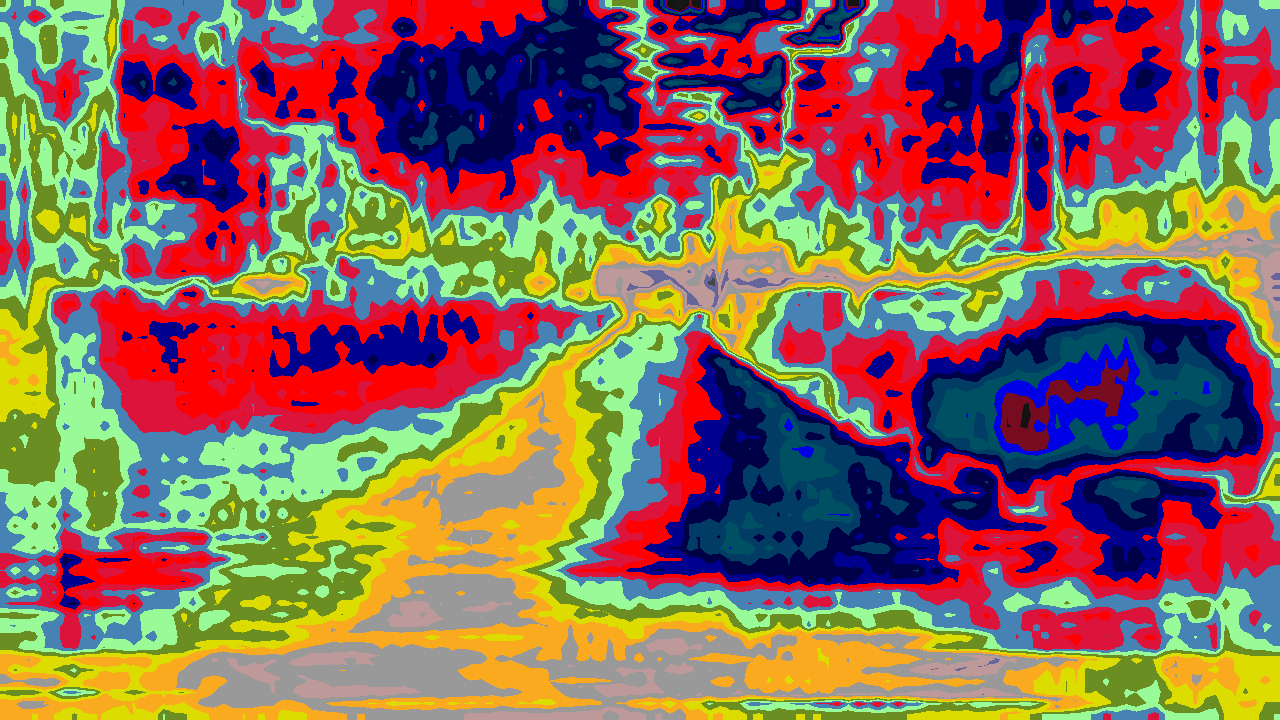

In [92]:
get_colorful_image

In [113]:
output = np.asarray(np.argmax(output, axis=2), dtype=np.uint8)
output.shape

(720, 1280)

In [114]:
output

array([[8, 8, 8, ..., 2, 2, 2],
       [8, 8, 8, ..., 2, 2, 2],
       [8, 8, 8, ..., 2, 2, 2],
       ...,
       [9, 9, 9, ..., 0, 0, 0],
       [9, 9, 9, ..., 0, 0, 0],
       [9, 9, 9, ..., 0, 0, 0]], dtype=uint8)

In [115]:
get_colorful_image = colorize_mask(output)
get_image = Image.fromarray(output)

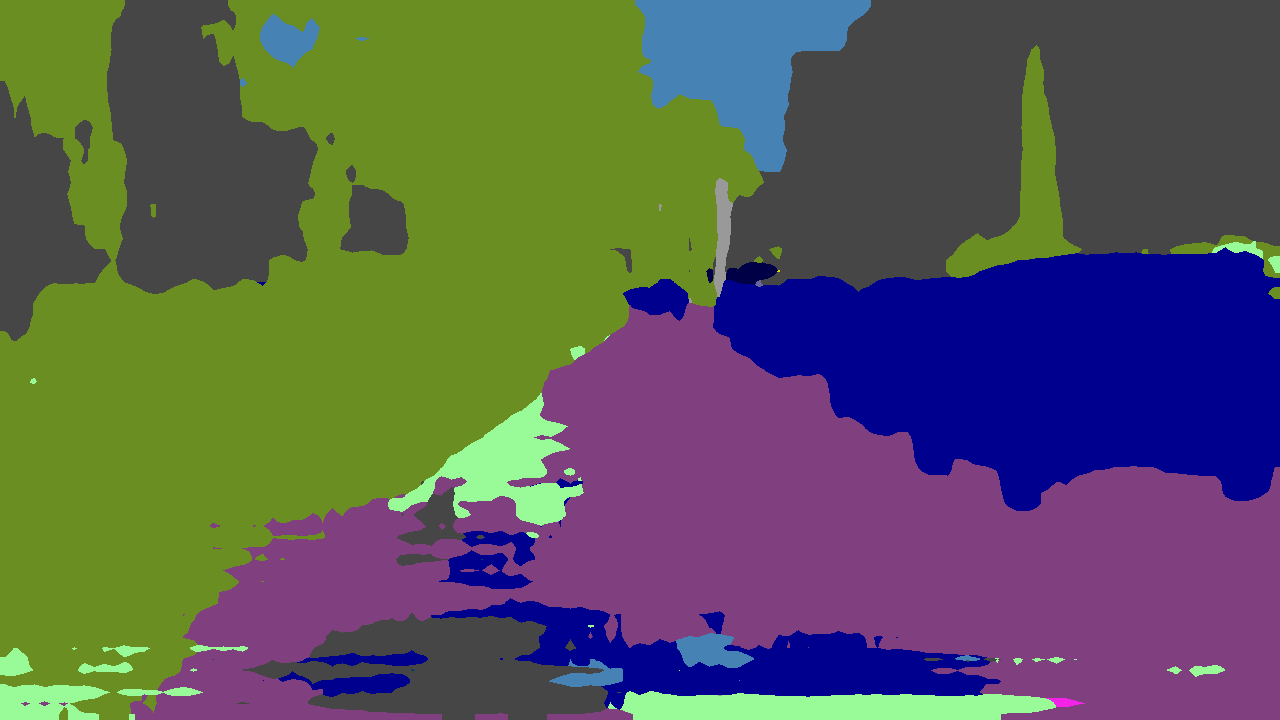

In [116]:
get_colorful_image

In [ ]:
del img_var, output1, output2

# discriminator check

In [ ]:
from model.discriminator import FCDiscriminator

In [ ]:
# init D
model_D1 = FCDiscriminator(num_classes=args.num_classes)
model_D2 = FCDiscriminator(num_classes=args.num_classes)
# model_D1.train()
model_D1.cuda(args.gpu)
# model_D2.train()
model_D2.cuda(args.gpu)

In [ ]:
pred_target1, pred_target2 = model(Variable(image, volatile=True).cuda(gpu0))
pred_target1 = interp_target(pred_target1)
pred_target2 = interp_target(pred_target2)

In [ ]:
pred_target1.shape

In [ ]:
F.softmax(pred_target1).shape

In [41]:
output = output.transpose(1,2,0)
output = np.asarray(np.argmax(output, axis=2), dtype=np.uint8)

TypeError: transpose() takes 2 positional arguments but 3 were given

In [ ]:
output_d = model_D1(F.softmax(pred_target1))

In [ ]:
output_d.shape

In [ ]:
del pred_target1, pred_target2, output_d

# test my discriminator

In [ ]:
from model.xiao_discriminator import XiaoDiscriminator

In [ ]:
from importlib import reload
reload(XiaoDiscriminator)


In [ ]:
# init D
model_D1 = XiaoDiscriminator(num_classes=args.num_classes)
model_D1.cuda(args.gpu)

In [ ]:
pred_target1, pred_target2 = model(Variable(image, volatile=True).cuda(gpu0))

In [ ]:
pred_target1 = interp_target(pred_target1)
pred_target2 = interp_target(pred_target2)

In [ ]:
output_d = model_D1(F.softmax(pred_target1))

In [ ]:
output_d.shape

In [ ]:
del pred_target1, pred_target2, output_d